In [16]:
pip install nibabel

Note: you may need to restart the kernel to use updated packages.


This file is done by Tera Keshavardan Reddy

In [17]:
import numpy as np
import os

import nibabel as nib

import torch

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

# Dataset

In [18]:
# New for nii dataset class

class BRATS2021Dataset(Dataset):

    def __init__(self, root_dir, transform=None):

        """

        Args:

            root_dir (string): Directory with all patient folders containing .nii files.

            transform (callable, optional): Optional transform to apply on a sample.

        """

        self.root_dir = root_dir

        self.patients = sorted(os.listdir(root_dir))  # List of patient folders

        self.transform = transform



    def __len__(self):

        return len(self.patients)



    def __getitem__(self, idx):

        patient_dir = os.path.join(self.root_dir, self.patients[idx])



        # Define the modality filenames

        flair_path = os.path.join(patient_dir, f"{self.patients[idx]}_flair.nii")

        t1_path = os.path.join(patient_dir, f"{self.patients[idx]}_t1.nii")

        t1ce_path = os.path.join(patient_dir, f"{self.patients[idx]}_t1ce.nii")

        t2_path = os.path.join(patient_dir, f"{self.patients[idx]}_t2.nii")

        seg_path = os.path.join(patient_dir, f"{self.patients[idx]}_seg.nii")



        # Load modalities using nibabel

        flair = nib.load(flair_path).get_fdata(dtype=np.float32)

        t1 = nib.load(t1_path).get_fdata(dtype=np.float32)

        t1ce = nib.load(t1ce_path).get_fdata(dtype=np.float32)

        t2 = nib.load(t2_path).get_fdata(dtype=np.float32)

        



        # Stack modalities into a single tensor (e.g., shape: [4, H, W, D])

        modalities = torch.tensor(np.stack([flair, t1, t1ce, t2], axis=0))



        # Load segmentation

        seg = nib.load(seg_path).get_fdata(dtype=np.float32)

        segmentation = torch.tensor(seg, dtype=torch.long)



        # Apply transformations if any

        if self.transform:

            modalities = self.transform(modalities)

            segmentation = self.transform(segmentation)

        modalities = modalities.squeeze(dim=1)

        segmentation = segmentation.squeeze(dim=0)

        # modalities = modalities.permute(1, 2, 3, 0)

        segmentation[segmentation == 4] = 2



        return modalities, segmentation



transform = transforms.Compose([

    transforms.Normalize(mean=[0.5, 0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5, 0.5])  # Normalize modalities

])


In [19]:
train_dir = "D:/swin-dataset/Processed_BraTS2021/train" 

train_dataset = BRATS2021Dataset(root_dir=train_dir)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)



test_dir = "D:/swin-dataset/Processed_BraTS2021/test"   

test_dataset = BRATS2021Dataset(root_dir=test_dir)

test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)



validation_dir = "D:/swin-dataset/Processed_BraTS2021/val"     # Change to your dataset path

validation_dataset = BRATS2021Dataset(root_dir=validation_dir)

validation_dataloader = DataLoader(validation_dataset, batch_size=2, shuffle=True)

In [20]:
img = next(iter(train_dataloader))

In [21]:
img[1].shape

torch.Size([2, 64, 64, 64])

# U-net Architecture

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv3D(nn.Module):
    """Two 3D convolutions followed by BatchNorm and ReLU activation."""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv3D, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)


class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        # Encoder
        self.enc1 = DoubleConv3D(in_channels, 32)
        self.enc2 = DoubleConv3D(32, 64)
        self.enc3 = DoubleConv3D(64, 128)
        self.enc4 = DoubleConv3D(128, 256)

        # Down-sampling
        self.pool = nn.MaxPool3d(2)

        # Bottleneck
        self.bottleneck = DoubleConv3D(256, 512)

        # Decoder
        self.up4 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        self.dec4 = DoubleConv3D(512, 256)

        self.up3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv3D(256, 128)

        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec2 = DoubleConv3D(128, 64)

        self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = DoubleConv3D(64, 32)

        # Output layer
        self.out_conv = nn.Conv3d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder path
        dec4 = self.up4(bottleneck)
        dec4 = self.dec4(torch.cat([dec4, enc4], dim=1))

        dec3 = self.up3(dec4)
        dec3 = self.dec3(torch.cat([dec3, enc3], dim=1))

        dec2 = self.up2(dec3)
        dec2 = self.dec2(torch.cat([dec2, enc2], dim=1))

        dec1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([dec1, enc1], dim=1))

        # Output layer
        out = self.out_conv(dec1)
        return out






# print(f"Output shape: {output.shape}")


# Dice Loss

In [23]:
import torch

import torch.nn as nn

import torch.nn.functional as F



class DiceLoss(nn.Module):

    def __init__(self, smooth=1e-6):

        super(DiceLoss, self).__init__()

        self.smooth = smooth



    def forward(self, preds, targets):

        """

        Computes the Dice Loss for multi-class segmentation.

        

        Args:

            preds (torch.Tensor): Predicted tensor of shape (B, C, H, W, D) with raw logits.

            targets (torch.Tensor): Ground truth tensor of shape (B, H, W, D) with class indices.

        

        Returns:

            torch.Tensor: The Dice Loss.

        """

        # Apply softmax to get class probabilities

        preds = F.softmax(preds, dim=1)  # Softmax along the channel axis

        

        # Get the number of classes from predictions

        num_classes = preds.shape[1]

        

        # Convert targets to one-hot encoding of shape (B, C, H, W, D)

        targets_one_hot = F.one_hot(targets, num_classes=num_classes)  # Shape: (B, H, W, D, C)

        targets_one_hot = targets_one_hot.permute(0, 4, 1, 2, 3).float()  # Shape: (B, C, H, W, D)

        

        # Compute Dice Loss per class

        dice_loss = 0

        for c in range(num_classes):

            pred_flat = preds[:, c].contiguous().view(-1)

            target_flat = targets_one_hot[:, c].contiguous().view(-1)

            intersection = (pred_flat * target_flat).sum()

            dice_score = (2. * intersection ) / (pred_flat.sum() + target_flat.sum() + self.smooth)

            dice_loss += 1 - dice_score



        # Average Dice Loss across all classes

        return dice_loss / num_classes


# Training Loop

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm



# Validation loop
def validate(model, val_loader, device='cuda'):
    """
    Validation loop for the U-Net model.
    Args:
        model (torch.nn.Module): U-Net model.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        device (str): Device to use ('cuda' or 'cpu').
    """
    model.eval()  # Set model to evaluation mode
    dice_loss_fn = DiceLoss()
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation during validation
        with tqdm(val_loader, desc="Validation") as t:
            for data, target in t:
                data, target = data.to(device), target.to(device)
                output = model(data)  # Forward pass
                loss = dice_loss_fn(output, target)  # Compute Dice loss
                val_loss += loss.item()  # Accumulate validation loss
                t.set_postfix(loss=loss.item())  # Update tqdm with current loss

    avg_val_loss = val_loss / len(val_loader)  # Calculate average validation loss
    return avg_val_loss  # Return average loss to step the scheduler


# Training loop
def train(model, train_loader, val_loader, optimizer, num_epochs=10, device='cuda'):
    """
    Training loop for the U-Net model.
    Args:
        model (torch.nn.Module): U-Net model.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        num_epochs (int): Number of epochs to train.
        device (str): Device to use ('cuda' or 'cpu').
    """
    model = model.to(device)
    dice_loss_fn = DiceLoss()

    # Learning rate scheduler (optional)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_loss = 0.0
        epoch_train_loss = 0.0

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        with tqdm(train_loader, desc=f"Training Epoch {epoch + 1}") as t:
            for batch_idx, (data, target) in enumerate(t):
                data, target = data.to(device), target.to(device)

                optimizer.zero_grad()  # Clear gradients
                output = model(data)  # Forward pass
                loss = dice_loss_fn(output, target)  # Compute Dice loss
                loss.backward()  # Backpropagation
                optimizer.step()  # Update weights

                epoch_train_loss += loss.item()
                t.set_postfix(loss=loss.item())  # Update tqdm with current loss

        avg_train_loss = epoch_train_loss / len(train_loader)  # Calculate average training loss
        print(f"Epoch {epoch + 1} Average Training Loss: {avg_train_loss:.4f}")

        # Validation and learning rate scheduling
        val_loss = validate(model, val_loader, device)
        print(f"Validation Loss after Epoch {epoch + 1}: {val_loss:.4f}")
        
        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)  

        # Optionally, you can track the losses in a list for further analysis
        # This can be useful for plotting the loss curves later
        # training_losses.append(avg_train_loss)
        # validation_losses.append(val_loss)



In [ ]:
from torch.optim import Adam

in_channels = 4  
out_channels = 3  
model = UNet3D(in_channels, out_channels)
# x = torch.randn(1, in_channels, 64, 64, 64) 
# output = model(x)
optimizer = Adam(model.parameters(), lr=1e-4)
train(model, train_dataloader, validation_dataloader, optimizer=optimizer,num_epochs=100, device='cuda')

In [36]:
class BRATS2021NewDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all patient folders containing .nii files.
            transform (callable, optional): Optional transform to apply on a sample.
        """
        self.root_dir = root_dir
        self.patients = sorted(os.listdir(root_dir))  # List of patient folders
        self.transform = transform

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_dir = os.path.join(self.root_dir, self.patients[idx])

        # Define the modality filenames
        flair_path = os.path.join(patient_dir, f"{self.patients[idx]}_flair.nii")
        t1_path = os.path.join(patient_dir, f"{self.patients[idx]}_t1.nii")
        t1ce_path = os.path.join(patient_dir, f"{self.patients[idx]}_t1ce.nii")
        t2_path = os.path.join(patient_dir, f"{self.patients[idx]}_t2.nii")
        seg_path = os.path.join(patient_dir, f"{self.patients[idx]}_seg.nii")
        classification_path = os.path.join(patient_dir, "classification.txt")

        # Load modalities using nibabel
        flair = nib.load(flair_path).get_fdata(dtype=np.float32).squeeze(axis=0)
        t1 = nib.load(t1_path).get_fdata(dtype=np.float32).squeeze(axis=0)
        t1ce = nib.load(t1ce_path).get_fdata(dtype=np.float32).squeeze(axis=0)
        t2 = nib.load(t2_path).get_fdata(dtype=np.float32).squeeze(axis=0)

        # Stack modalities into a single tensor (e.g., shape: [4, H, W, D])
        modalities = torch.tensor(np.stack([flair, t1, t1ce, t2], axis=0))

        # Load the segmentation labels
        seg = nib.load(seg_path).get_fdata(dtype=np.float32).astype(np.uint8).squeeze(axis=0)
                
        # Convert the segmentation to a tensor
        segmentation = torch.tensor(seg, dtype=torch.long)

        # Load the classification label
        with open(classification_path, "r") as f:
            lines = f.readlines()
            patient_id = lines[0].split(":")[1].strip()  # Extract Patient ID
            tumor_grade = lines[1].split(":")[1].strip()  # Extract Tumor Grade

        # Apply transformations if any
        if self.transform:
            modalities = self.transform(modalities)

        # Adjust dimensions if necessary (if the shape is [B, C, 1, H, W, D])
        modalities = modalities.squeeze(dim=2)
        
        # Rearrange the modalities to [H, W, D, C] for compatibility
        # modalities = modalities.permute(1, 2, 3, 0)

        # Return modalities, segmentation, and classification info
        return modalities, segmentation, {"patient_id": patient_id, "tumor_grade": tumor_grade}


# New Dataset Preparation

In [43]:
import os
import torch

# Directory paths
root_dir = "D:/swin-dataset/Processed_BraTS2021/val"
new_dataset_dir = "D:/dataset"

# Ensure the new dataset directory exists
os.makedirs(new_dataset_dir, exist_ok=True)

# Instantiate the dataset
dataset = BRATS2021NewDataset(root_dir=root_dir)
device='cuda'
# Process and save new dataset
with torch.no_grad():  # Disable gradient computation for inference
    for idx in range(len(dataset)):
        modalities, _, classification_info = dataset[idx]

        patient_id = classification_info["patient_id"]
        tumor_grade = classification_info["tumor_grade"]

        
        modalities = modalities.unsqueeze(0).to(device)  

        model_output = model(modalities) 
        predicted_segmentation = model_output.squeeze(0)  

        predicted_segmentation = predicted_segmentation.cpu()
        modalities = modalities.cpu().squeeze(0)  

        # Create a new directory for the patient
        patient_folder = dataset.patients[idx]
        new_patient_dir = os.path.join(new_dataset_dir, patient_folder)
        os.makedirs(new_patient_dir, exist_ok=True)

        segmentation_path = os.path.join(new_patient_dir, "segmentation.pt")
        torch.save(predicted_segmentation, segmentation_path)

        classification_path = os.path.join(new_patient_dir, "classification.txt")
        with open(classification_path, "w") as f:
            f.write(f"Patient ID: {patient_id}\n")
            f.write(f"Tumor grade: {tumor_grade}\n")

print("New dataset created successfully with model-generated 3-channel segmentations!")


New dataset created successfully with model-generated 3-channel segmentations!


In [44]:
class BRATS2021NewDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all patient folders containing .pt and .txt files.
            transform (callable, optional): Optional transform to apply on a sample.
        """
        self.root_dir = root_dir
        self.patients = sorted(os.listdir(root_dir))  # List of patient folders
        self.transform = transform

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_dir = os.path.join(self.root_dir, self.patients[idx])

        # Load the segmentation tensor (shape: [H, W, D])
        segmentation_path = os.path.join(patient_dir, "segmentation.pt")
        segmentation = torch.load(segmentation_path)

        # Load the classification label from text file
        classification_path = os.path.join(patient_dir, "classification.txt")
        with open(classification_path, "r") as f:
            lines = f.readlines()
            patient_id = lines[0].split(":")[1].strip()  # Extract Patient ID
            tumor_grade = lines[1].split(":")[1].strip()  # Extract Tumor Grade

        # Apply transformations if any
        if self.transform:
            modalities = self.transform(modalities)

        # Return modalities, segmentation, and classification info
        return  segmentation, {"patient_id": patient_id, "tumor_grade": tumor_grade}


In [53]:
from torch.utils.data import DataLoader

# Paths
root_dir = "D:/dataset"  

# Create dataset instance
dataset = BRATS2021NewDataset(root_dir=root_dir)

# Create DataLoader
batch_size = 2  # Adjust batch size as per available memory
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)



torch.Size([3, 64, 64, 64])


/tmp/ipykernel_30/264144164.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation = torch.load(segmentation_path)


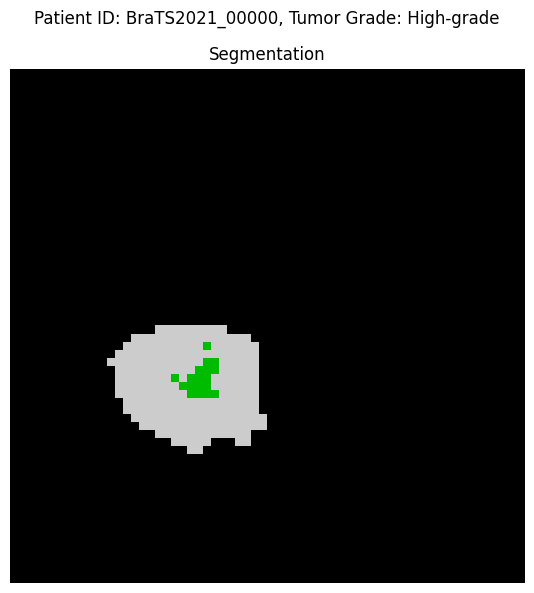

torch.Size([3, 64, 64, 64])


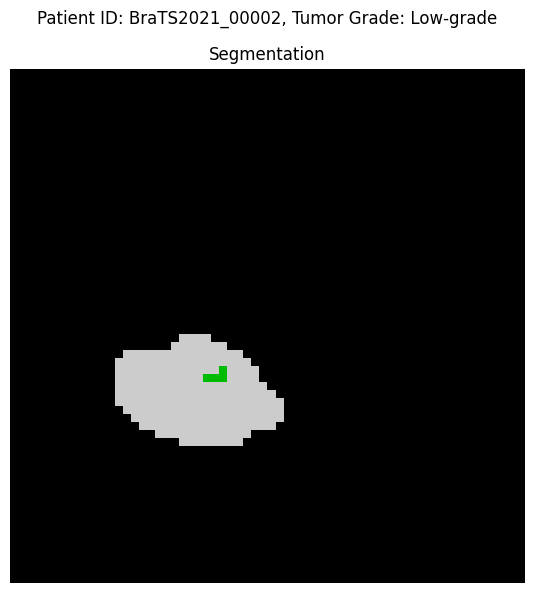

torch.Size([3, 64, 64, 64])


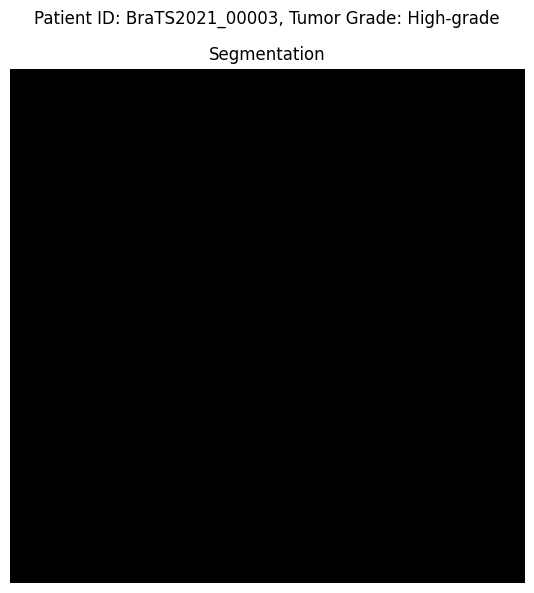

In [52]:
import matplotlib.pyplot as plt
import torch

def visualize_patient_data(segmentation, classification_info, slice_idx=None, axis=2):
    """
    Visualizes the segmentation for a single patient.
    Args:
        segmentation (torch.Tensor): Tensor of shape [C, H, W, D] or [H, W, D] (segmentation mask).
        classification_info (dict): Patient classification info with `patient_id` and `tumor_grade`.
        slice_idx (int, optional): Specific slice index to visualize along the given axis. If None, the middle slice is used.
        axis (int): Axis along which to slice (0, 1, or 2).
    """
    segmentation = segmentation.numpy()

    # Handle multi-channel segmentation (e.g., [C, H, W, D])
    if segmentation.ndim == 4:
        segmentation = segmentation.argmax(axis=0)  # Combine channels to a single mask

    if slice_idx is None:
        # Default to the middle slice along the specified axis
        slice_idx = segmentation.shape[axis] // 2

    # Create a figure
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    fig.suptitle(f"Patient ID: {classification_info['patient_id']}, Tumor Grade: {classification_info['tumor_grade']}")

    # Extract the slice along the specified axis
    if axis == 0:
        segmentation_slice = segmentation[slice_idx, :, :]
    elif axis == 1:
        segmentation_slice = segmentation[:, slice_idx, :]
    else:  # axis == 2
        segmentation_slice = segmentation[:, :, slice_idx]

    ax.imshow(segmentation_slice, cmap="nipy_spectral")
    ax.set_title("Segmentation")
    ax.axis("off")

    plt.tight_layout()
    plt.show()

for idx in range(3):
    segmentation, classification_info = dataset[idx]
    print(segmentation.shape)
    visualize_patient_data(segmentation, classification_info)


In [58]:
import re

# File path to your text file
log_file_path = "D:/progress-unet/unet.txt"

# Initialize empty lists for epochs, training losses, and validation losses
epochs = []
training_losses = []
validation_losses = []

# Open the file and parse each line
with open(log_file_path, "r") as file:
    for line in file:
        # Match Epoch number
        epoch_match = re.search(r"Epoch (\d+)/\d+", line)
        if epoch_match:
            epochs.append(int(epoch_match.group(1)))
        
        # Match Training Loss
        train_loss_match = re.search(r"Epoch \d+ Average Training Loss: ([\d.]+)", line)
        if train_loss_match:
            training_losses.append(float(train_loss_match.group(1)))
        
        # Match Validation Loss
        val_loss_match = re.search(r"Validation Loss after Epoch \d+: ([\d.]+)", line)
        if val_loss_match:
            validation_losses.append(float(val_loss_match.group(1)))

# Print extracted data
print("Epochs:", epochs)
print("Training Losses:", training_losses)
print("Validation Losses:", validation_losses)



Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
Training Losses: [0.7262, 0.6384, 0.554, 0.4718, 0.398, 0.3157, 0.2624, 0.2346, 0.216, 0.207, 0.1952, 0.1883, 0.191, 0.1825, 0.1791, 0.167, 0.1628, 0.1621, 0.1553, 0.1536, 0.1557, 0.1539, 0.155, 0.1551, 0.1564, 0.154, 0.1553, 0.1524, 0.1545, 0.1544, 0.1537, 0.1563, 0.155, 0.1547, 0.1557, 0.1529, 0.154, 0.153, 0.1551, 0.1528, 0.151, 0.157, 0.1529, 0.1579, 0.1546, 0.1551]
Validation Losses: [0.6852, 0.5964, 0.5144, 0.4452, 0.401, 0.3805, 0.2674, 0.2415, 0.253, 0.297, 0.2111, 0.4388, 0.4508, 0.2257, 0.233, 0.1842, 0.1936, 0.2393, 0.2499, 0.1929, 0.2238, 0.1861, 0.1863, 0.2094, 0.2341, 0.191, 0.1797, 0.1879, 0.1856, 0.1852, 0.1894, 0.1834, 0.1841, 0.1943, 0.1836, 0.2319, 0.2218, 0.2595, 0.1885, 0.186, 0.1971, 0.1852, 0.179, 0.2294, 0.1883, 0.1887]


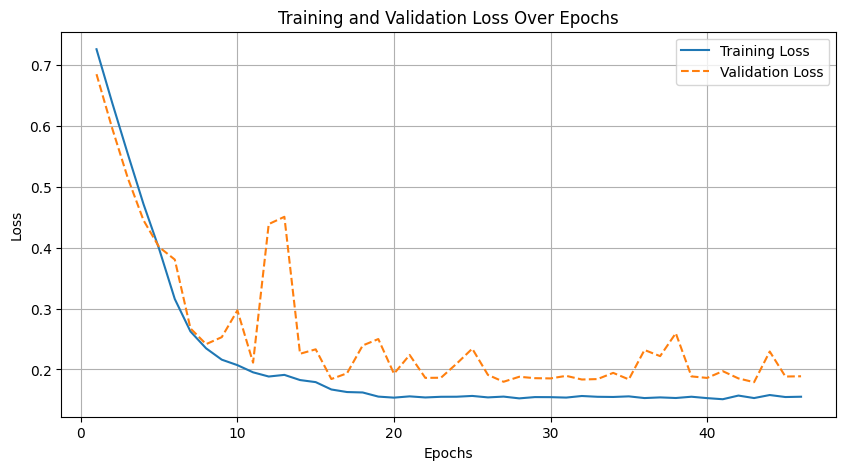

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label="Training Loss")
plt.plot(epochs, validation_losses, label="Validation Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [81]:
import torch

import torch.nn as nn

import torch.nn.functional as F



class EfficientNet3D(nn.Module):

    def __init__(self, input_channels=1, num_classes=2):  # Default input channels to 1

        super(EfficientNet3D, self).__init__()



        # Initial Conv3D layer with dynamic input channels (e.g., 1 for grayscale or 3 for multi-channel)

        self.conv1 = nn.Conv3d(input_channels, 32, kernel_size=3, stride=1, padding=1)

        self.bn1 = nn.BatchNorm3d(32)

        self.relu1 = nn.ReLU()



        # Efficient 3D blocks (a few layers for simplicity)

        self.block1 = self._make_block(32, 64)

        self.block2 = self._make_block(64, 128)

        self.block3 = self._make_block(128, 256)



        # Global average pooling layer (to handle variable input size)

        self.global_avg_pool = nn.AdaptiveAvgPool3d(1)



        # Fully connected layers for classification

        self.fc1 = nn.Linear(256, 512)

        self.fc2 = nn.Linear(512, num_classes)  # Output layer changed to 2 classes



        # Dropout for regularization

        self.dropout = nn.Dropout(0.5)



    def _make_block(self, in_channels, out_channels):

        # A helper function to create 3D convolution blocks

        return nn.Sequential(

            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),

            nn.BatchNorm3d(out_channels),

            nn.ReLU(),

            nn.MaxPool3d(2)

        )



    def forward(self, x):

        # Pass through the initial convolution and the blocks

        x = self.relu1(self.bn1(self.conv1(x)))



        # Block 1, Block 2, Block 3

        x = self.block1(x)

        x = self.block2(x)

        x = self.block3(x)



        # Global average pooling to ensure size consistency

        x = self.global_avg_pool(x)

        x = torch.flatten(x, 1)  # Flatten to (batch_size, num_features)



        # Fully connected layers

        x = self.dropout(F.relu(self.fc1(x)))

        x = self.fc2(x)  # No sigmoid here because we'll use softmax during loss computation



        return x




In [79]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class BRATS2021Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Root directory where each patient folder contains segmentation (.pt) and classification.txt.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.patients = sorted(os.listdir(root_dir))  # List of patient folders
        self.transform = transform

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_folder = self.patients[idx]
        patient_dir = os.path.join(self.root_dir, patient_folder)

        # Extract patient ID
        patient_id = patient_folder

        # Define the segmentation file path
        segmentation_path = os.path.join(patient_dir, "segmentation.pt")
        if not os.path.exists(segmentation_path):
            raise FileNotFoundError(f"Segmentation file not found: {segmentation_path}")

        # Load the segmentation file using PyTorch
        segmentation = torch.load(segmentation_path)
        # segmentation = segmentation.permute(1, 2, 3, 0)
        segmentation = segmentation.float() / 255.0  # If the values are in [0, 255]

        # Parse the classification.txt file to get the tumor grade
        classification_file = os.path.join(patient_dir, "classification.txt")
        if not os.path.exists(classification_file):
            raise FileNotFoundError(f"Classification file not found: {classification_file}")

        with open(classification_file, 'r') as f:
            lines = f.readlines()
            tumor_grade = lines[1].strip()  # Assuming second line contains the tumor grade

        # Remove the prefix "Tumor grade: " if present
        tumor_grade = tumor_grade.replace("Tumor grade: ", "").strip()

        # Convert tumor grade to a numeric label (e.g., 0 for low-grade, 1 for high-grade)
        if tumor_grade == "Low-grade":
            tumor_label = 0
        elif tumor_grade == "High-grade":
            tumor_label = 1
        else:
            raise ValueError(f"Unknown tumor grade: {tumor_grade}")

        # Apply transformations if any
        if self.transform:
            segmentation = self.transform(segmentation)

        # Return the segmentation and corresponding tumor label
        return segmentation, tumor_label


# Example transformation (e.g., normalization, resizing)
transform = transforms.Compose([
    # Example: Normalize the data
    transforms.Normalize(mean=[0.5], std=[0.5]),
])




In [ ]:
import os
import shutil
import random

# Path to your main dataset directory (where your patient folders are)
dataset_path = 'D:/dataset'

# Create directories for train, test, and val datasets
train_dir = 'D:/ClassDataset/train'
val_dir = 'D:/ClassDataset/val'
test_dir = 'D:/ClassDataset/test'

# Make directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get list of all patient directories (e.g., BraTS2021_00000)
patient_folders = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Split the patient folders into train, validation, and test sets
train_size = 0.7  # 70% for training
val_size = 0.15   # 15% for validation
test_size = 0.15  # 15% for testing

# Shuffle the patient folders
random.shuffle(patient_folders)

# Split based on the proportions
train_split = patient_folders[:int(train_size * len(patient_folders))]
val_split = patient_folders[int(train_size * len(patient_folders)):int((train_size + val_size) * len(patient_folders))]
test_split = patient_folders[int((train_size + val_size) * len(patient_folders)):]

# Function to move patient folders to their respective directories
def move_patient_folders(patient_folders, source_dir, target_dir):
    for folder in patient_folders:
        source_folder = os.path.join(source_dir, folder)
        target_folder = os.path.join(target_dir, folder)
        shutil.copytree(source_folder, target_folder)

# Move the folders into the train, validation, and test directories
move_patient_folders(train_split, dataset_path, train_dir)
move_patient_folders(val_split, dataset_path, val_dir)
move_patient_folders(test_split, dataset_path, test_dir)

print(f"Dataset split completed: {len(train_split)} train, {len(val_split)} validation, {len(test_split)} test")


In [83]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class BRATS2021Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Root directory where each patient folder contains segmentation (.pt) and classification.txt.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.patients = sorted(os.listdir(root_dir))  
        self.transform = transform

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_folder = self.patients[idx]
        patient_dir = os.path.join(self.root_dir, patient_folder)

        # Extract patient ID
        patient_id = patient_folder

        segmentation_path = os.path.join(patient_dir, "segmentation.pt")
        if not os.path.exists(segmentation_path):
            raise FileNotFoundError(f"Segmentation file not found: {segmentation_path}")

        segmentation = torch.load(segmentation_path)
        # segmentation = segmentation.permute(1, 2, 3, 0)
        segmentation = segmentation.float() / 255.0  # If the values are in [0, 255]

        # Parse the classification.txt file to get the tumor grade
        classification_file = os.path.join(patient_dir, "classification.txt")
        if not os.path.exists(classification_file):
            raise FileNotFoundError(f"Classification file not found: {classification_file}")

        with open(classification_file, 'r') as f:
            lines = f.readlines()
            tumor_grade = lines[1].strip()  

        # Remove the prefix "Tumor grade: " if present
        tumor_grade = tumor_grade.replace("Tumor grade: ", "").strip()

        # Convert tumor grade to a numeric label (e.g., 0 for low-grade, 1 for high-grade)
        if tumor_grade == "Low-grade":
            tumor_label = 0
        elif tumor_grade == "High-grade":
            tumor_label = 1
        else:
            raise ValueError(f"Unknown tumor grade: {tumor_grade}")

        # Apply transformations if any
        if self.transform:
            segmentation = self.transform(segmentation)

        # Return the segmentation and corresponding tumor label
        return segmentation, tumor_label


# Example transformation (e.g., normalization, resizing)
transform = transforms.Compose([
    # Example: Normalize the data
    transforms.Normalize(mean=[0.5], std=[0.5]),
])




In [84]:
# Example usage
from torch.utils.data import DataLoader

train_dir = "D:/ClassDataset/train"   

dataset = BRATS2021Dataset(root_dir=train_dir, transform=transform)



# Example DataLoader

train_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)



val_dir = "D:/ClassDataset/val"    

dataset = BRATS2021Dataset(root_dir=val_dir, transform=transform)



# Example DataLoader

val_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)


test_dir = "D:/ClassDataset/test"   

dataset = BRATS2021Dataset(root_dir=test_dir, transform=transform)



# Example DataLoader

test_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import os

# Assuming `EfficientNet3D` and DataLoaders (train_loader, val_loader) are defined
model = EfficientNet3D(input_channels=3, num_classes=2)  # 2 classes for binary classification

# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function with class weights (if applicable)
class_weights = torch.tensor([1.0, 2.0])  # Example: Adjust weights based on class imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Data augmentation (optional, depending on the dataset)
# Add data augmentation in your DataLoader preprocessing pipeline if not already present.

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=100):
    model.train()  # Set model to training mode
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero gradients
            outputs = model(inputs)  # Forward pass

            loss = criterion(outputs, labels)  # Loss computation
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = 100 * correct / total

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation loop
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Learning rate adjustment
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies


# Evaluation function
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss, correct, total = 0.0, 0, 0

    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    # Optional: Print detailed classification metrics
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=["Low-grade", "High-grade"]))

    return val_loss, val_accuracy


# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=100
)
